In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate

rcParams['font.size'] = 16
rcParams['lines.linewidth'] = 2

from compton.spectrum import Trajectory, Spectrum, SpectrumOAM
from compton.utils import Stokes_parameters, Lorentz_harm

In [2]:
# Create an instance of Trajectory class and calculate a trajectory
# of an electron in a defined EM field

u0, r0 = np.array([0.,0.,0.]), np.array([0.,0.,0.])
traj = Trajectory(u0, r0)

# Laser pulse parameters
tau = 10 * 2 * np.pi  # Pulse duration
a0 = 1               # Pulse amplitude
mode = 'rectangle'       # Temporal envelope
polarization = 'circular'
delta = 1

def envelope(x, mode='gauss'):
    if mode == 'rectangle':
        idx = (x >= -tau/2) & (x <= tau/2)
        g = np.zeros_like(x)
        g[idx] = 1
    elif mode == 'super gauss':
        g = np.exp(-(x/tau)**60)
    elif mode == 'gauss':
        g = np.exp(-x**2/tau**2)
    return g

def phase(x):
    return x

envelope = np.vectorize(envelope)
phase = np.vectorize(phase)

def calc_A(x):
    ph = phase(x)
    if polarization == 'circular':
        return a0*envelope(x,mode=mode)*np.array([np.cos(ph), np.sin(ph)])
    elif polarization == 'linear':
        return a0*envelope(x,mode=mode)*np.array([np.cos(ph), np.zeros_like(ph)])

# Here we manually define `electron time` box, it depends on the envelope
eta_b = 1.*tau
eta = np.linspace(-eta_b, eta_b, int(2*eta_b*100))
A = calc_A(eta)
u, r = traj.calc_u_x(A, eta)

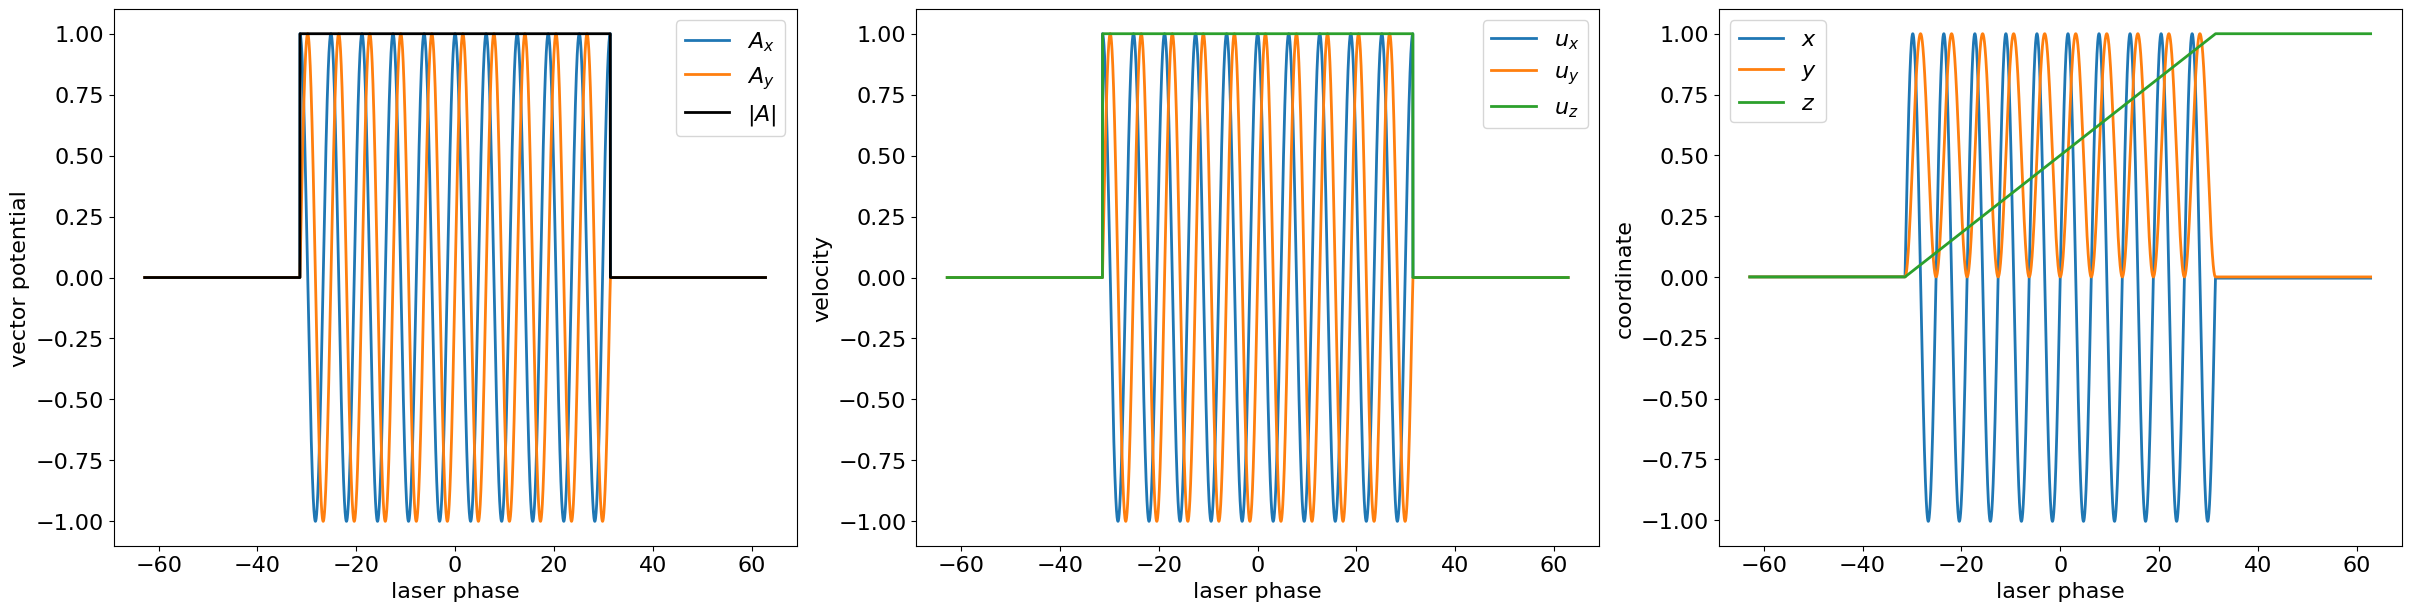

In [3]:
# Plot electron velocity and coordinate

A_mod = np.sqrt(A[0]**2 + A[1]**2)

plt.figure(figsize=(24, 6), layout='constrained')
plt.subplot(1,3,1)
plt.plot(eta, A[0]/np.max(A[0]), label='$A_x$')
plt.plot(eta, A[1]/np.max(A[1]), label='$A_y$')
plt.plot(eta, A_mod/np.max(A_mod), label='$|A|$', color='black')
plt.legend(loc='best')
plt.xlabel('laser phase')
plt.ylabel('vector potential')
# plt.show()

# fig, ax = plt.subplots(figsize=(10,8))
plt.subplot(1,3,2)
plt.plot(eta, u[0]/np.max(u[0]), label='$u_x$')
plt.plot(eta, u[1]/np.max(u[1]), label='$u_y$')
plt.plot(eta, u[2]/np.max(u[2]), label='$u_z$')
plt.legend(loc='best')
plt.xlabel('laser phase')
plt.ylabel('velocity')
# plt.show()

# fig, ax = plt.subplots(figsize=(10,8))
plt.subplot(1,3,3)
plt.plot(eta, r[0]/np.max(r[0]), label='$x$')
plt.plot(eta, r[1]/np.max(r[1]), label='$y$')
plt.plot(eta, r[2]/np.max(r[2]), label='$z$')
plt.legend(loc='best')
plt.xlabel('laser phase')
plt.ylabel('coordinate')
plt.show()

In [4]:
# Create an instance of Spectrum class and calculate the emission spectrum based on trajectories
spec = Spectrum(eta, u, r)

theta = np.pi
phi = 0
I, w = spec.calc_spectrum_I_w(theta=theta, phi=phi)

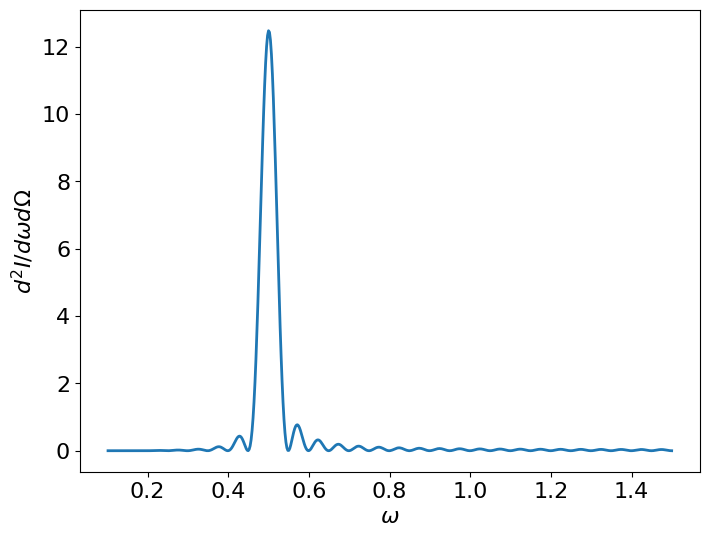

In [5]:
# Plot spectrum I(w)
w0, w1 = [0.1, 1.5]
idx = (w >= w0) & (w <= w1)
w_plot, I_plot = w[idx], I[idx]

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(w_plot, I_plot)
plt.xlabel('$\\omega$')
plt.ylabel('$d^2 I / d\\omega d\\Omega$')
plt.show()

### Investigate OAM
Here I compiled what I had in the OAM notebook to see that emitted light has OAM.

To see OAM in the simple setting we do the following:
1) specify part of the sphere at which we look at the emitted spectra:
    - **theta**: from theta_start to 2*pi
    - **phi**: from 0 to 2*pi
2) for every theta for a given envelope we estimate the position of harmonic **n** following analytic formula
3) for all thetas and phis we calculate the emitted spectrum at these partucular locations of harmonic peaks
4) we plot absolute values and phase of vector potential components and the number of full phase rotations = OAM
5) one can look at different components and see that they indeed correspond to n-1, n, n+1 OAM

In [6]:
spec = SpectrumOAM(eta, u, r, a0, delta)

In [7]:
theta_start = 1*np.pi/2
over_phi = True
n_theta = 300
n_phi = 200
n = 3

A_2D, w_grid, theta_grid, phi_grid = spec.spec_harm_angular(n_theta=n_theta, theta_start=theta_start,
                                                            n_phi=n_phi, over_phi=over_phi, n=n)

In [8]:
gamma = 10
A_L, w_L, theta_L = Lorentz_harm(A_2D, w_grid, theta_grid, phi_grid, gamma=gamma)

A_pol_comp = Stokes_parameters(A_L[:3])

In [9]:
def plot_OAM(A, theta_grid, phi_grid, theta_stop=0.1, idx_star=10, plot_angle=False):
    idx_theta = np.pi-theta_grid < theta_stop

    R = 1. * np.sin(np.pi - theta_grid[idx_theta])

    R_grid, phi_grid_new = np.meshgrid(R, phi_grid) 
    x1 = R_grid * np.cos(phi_grid_new)
    x2 = R_grid * np.sin(phi_grid_new)
    print(x1.shape, x2.shape)

    plt.figure(dpi=200)
    if plot_angle:
        plt.subplot(1,2,1)
    plt.pcolormesh(x1, x2, np.abs(A)[idx_theta].T, cmap='inferno',
                   rasterized=True)
    plt.axis('equal')
    plt.axis('off')
    if not plot_angle:
        plt.colorbar()
    if plot_angle:
        ax = plt.subplot(1,2,2)
        circle = plt.Circle((0, 0), R[-idx_star], fill=False, color='white', linewidth=1, linestyle='--',
                           zorder=5)
        ax.add_artist(circle)
        plt.pcolormesh(x1, x2, np.angle(A)[idx_theta].T, cmap='inferno',
                       rasterized=True)
        plt.axis('equal')
        plt.axis('off')
    plt.show()

    if plot_angle:
        plt.figure(dpi=100)
        plt.plot(phi_grid, np.angle(A)[idx_theta][-idx_star])
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

(200, 257) (200, 257)


/tmp/ipykernel_32543/3492482733.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x1, x2, np.abs(A)[idx_theta].T, cmap='inferno',
/tmp/ipykernel_32543/3492482733.py:25: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x1, x2, np.angle(A)[idx_theta].T, cmap='inferno',


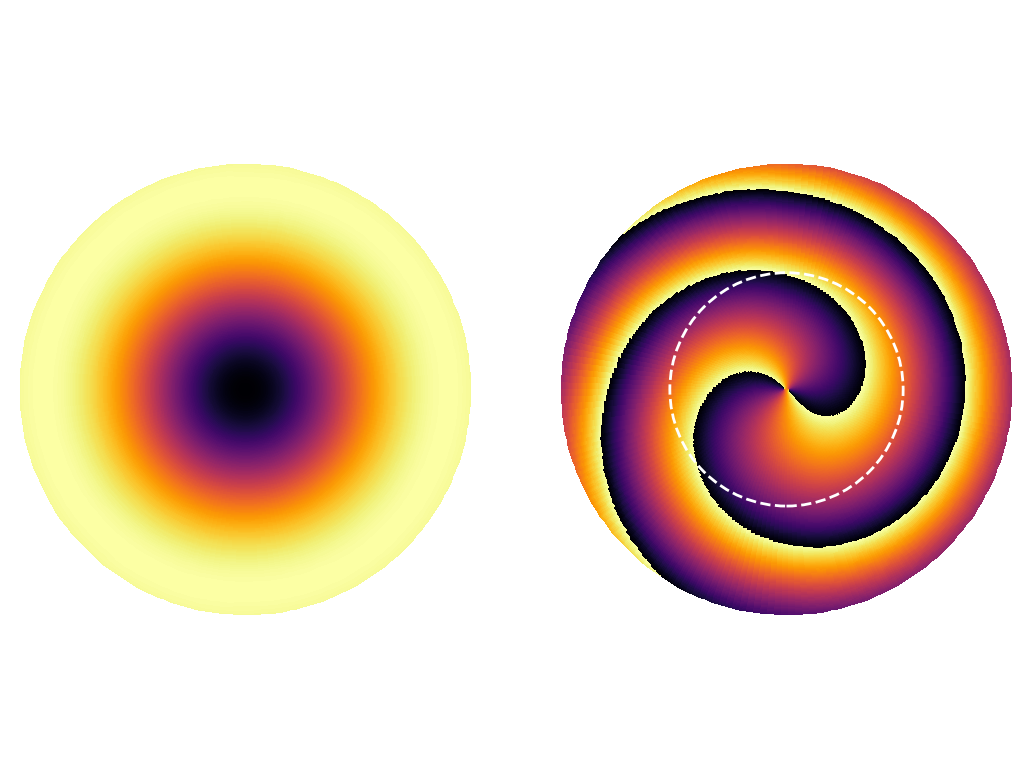

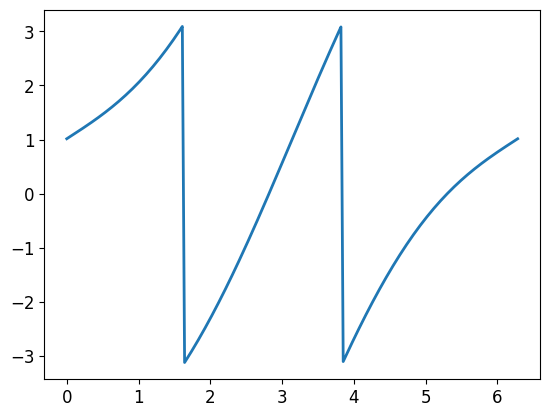

In [10]:
plot_OAM(A_pol_comp[0], theta_L, phi_grid, 0.08, 150, plot_angle=True)